In [37]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [38]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [39]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [40]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [42]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  10,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 2,
"pred_session_name" : 'rand_walk_interpol_2_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [43]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 1

2023-06-06 17:41:27.955961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:27.956223: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-06 17:41:27.956341: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-06 17:41:27.956646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:27.956869: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-06 17:41:28.718510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:28.718903: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-06 17:41:28.719042: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-06 17:41:28.719256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:28.719432: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-06 17:41:32.592449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:32.592655: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-06 17:41:32.592760: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-06 17:41:32.592999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:32.593186: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-06 17:41:33.060754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:33.061004: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-06 17:41:33.061281: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-06 17:41:33.062002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 17:41:33.062229: I tensorflow/compiler/xla/stream_executor/

In [44]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-06--17:41:41'

In [45]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [46]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:
# Use for time profiling
# def main():
#     env.ee.policy = "random"
#     env.ee.action_space.repeat_probability = 0.9
#     all_rewards = []
#     final_errors = []
    
#     for _ in range(1):
#         time_step = train_py_env.reset()
#         reward_in_episode = 0
#         while not time_step.is_last():
#             time_step = train_py_env.step(action=1)
#             reward_in_episode += time_step.reward
#         all_rewards.append(reward_in_episode)
#         final_errors.append(env.current_error)
#     print("Reward per epsisode", np.mean(all_rewards))
#     print("Average error", np.mean(final_errors))
#     env.ee.policy = "rl"

# %lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

In [47]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [48]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

In [50]:
# Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # # Create a timestep with TF values
        # step_type = tf.constant(time_steps[agent_idx].step_type)
        # reward = tf.constant(time_steps[agent_idx].reward)
        # discount = tf.constant(time_steps[agent_idx].discount)
        # observation = tf.constant(time_steps[agent_idx].observation)
        # tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(time_steps[0])
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors)

In [53]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True), n_agents, num_episodes=10)

print((rand_reward, rand_pred_error))


(23.687094144821167, 16.656862083375074)


In [54]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpsetfkner.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpsetfkner
[reverb/cc/platform/default/server.cc:71] Started replay server on port 38439
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [55]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps


KeyboardInterrupt: 

In [56]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [57]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
# This will be a list for multiple agents
time_step = train_py_env.reset()





In [58]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents = n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [60]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [61]:
best_reward = np.inf
losses = []
collect_rewards = []

In [62]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [71]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % 1 == 0:
    avg_return, avg_error = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), num_eval_episodes)
      avg_return_collect, avg_error_collect = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True), num_eval_episodes)
      print('step = {0}: Average Return 2 = {1}, Average Error 2 = {2}'.format(step, avg_return, avg_error))
      print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 7533: Average Return = 24.598416137695313, Average Error = 15.401583722592836
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-06--17:41:41/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-06--17:41:41/assets


In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

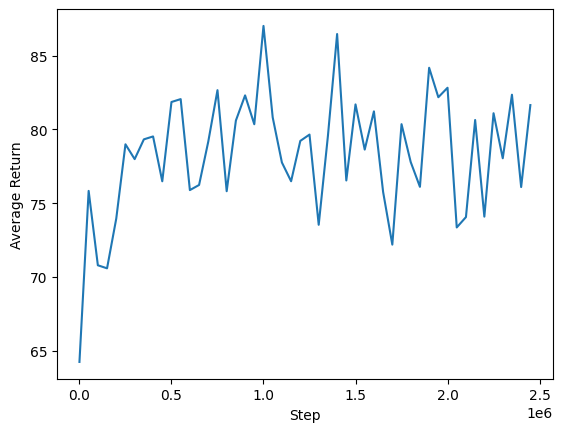

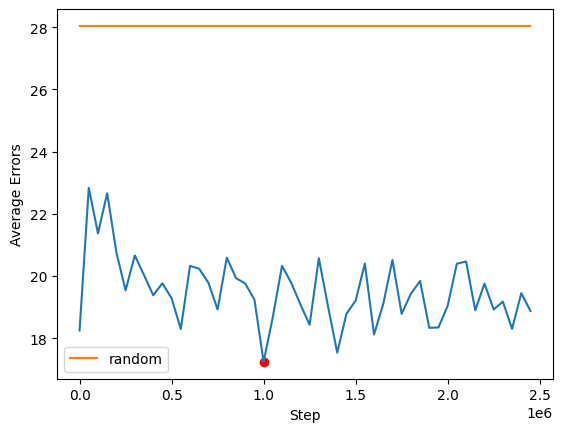

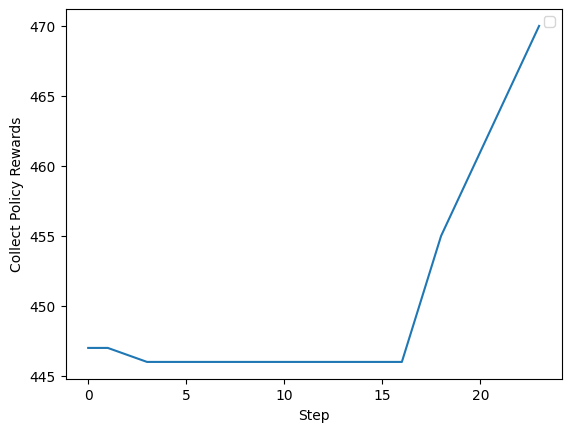

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.477695 17.715553957387616


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.378853 17.984891216551663


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, saved_policy, 500)
print(avg_return, avg_error)

22.074543 18.12299778895943
